Анализ и вывод статистики результов сегментации.

В этой тетради агрегируются нужные таблицы для предоставления и визуализации статистики по каждому из типов составных единиц. Полная статистика сохранена в отдельных файлах, в этой тетради можно увидеть таблицу с краткой статистикой и ее график.

Для визуализации выбирались только данные с наличием сегментации, неожиданной сегментации и неожиданного присоединения к соседним элементам. Данные об их отсутствии не визуализировались для удобства восприятия. Поэтому некоторых графиков нет. Это не ошибка, просто это означает, что, например, неожиданной сегментации обнаружено не было.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from itertools import product

In [2]:
# список названий парсеров

parsers = ['ipadic', 'jumandic', 'unidic']

In [3]:
# функция для агрегации таблиц с полной информацией по каждому типу составных единиц и парсеру;
# на вход берет название типа, название парсера и колонку в таблице

def show_statistics(kind, parser, column):
    folder = f'segmentation_analysis/{kind}/using_{parser}'
    analysis = pd.concat([
        pd.read_csv(f'{folder}/{filename}', index_col=0)
        for filename in os.listdir(folder)
    ], names=['index'])
    analysis['unit length'] = analysis['compound unit'].str.len()
    if kind == 'kango_with_postfixes':
        analysis['postfix'] = analysis['compound unit'].str.slice(start=-1)
        index_columns = ['postfix', 'unit length', 'compound unit']
    elif kind == 'kango_with_prefixes':
        analysis['prefix'] = analysis['compound unit'].str.slice(stop=1)
        index_columns = ['prefix', 'unit length', 'compound unit']
    else:
        index_columns = ['unit length', 'compound unit']
    analysis.set_index(index_columns, append=True, inplace=True)
    analysis_groupby = analysis[column].groupby(index_columns)
    statistics = pd.concat({
        'frequencies': analysis_groupby.value_counts().unstack(fill_value=0),
        'percentages': analysis_groupby.value_counts(normalize=True).unstack(fill_value=0)
    }, axis=1)
    return statistics

In [4]:
# функция для агрегации таблиц с ключевой информацией по каждому типу составных единиц и парсеру;
# на вход берет название типа, название парсера и колонку в таблице

def show_statistics_short(kind, parser, column):
    folder = f'segmentation_analysis/{kind}/using_{parser}'
    analysis = pd.concat([
        pd.read_csv(f'{folder}/{filename}', index_col=0)
        for filename in os.listdir(folder)
    ], names=['index'])
    if kind == 'kango_with_postfixes':
        analysis['postfix'] = analysis['compound unit'].str.slice(start=-1)
        index_columns = ['postfix', 'unit length', 'compound unit']
    elif kind == 'kango_with_prefixes':
        analysis['prefix'] = analysis['compound unit'].str.slice(stop=1)
        index_columns = ['prefix', 'unit length', 'compound unit']
    else:
        index_columns = ['unit length', 'compound unit']
    analysis['unit length'] = analysis['compound unit'].str.len()
    analysis.set_index(index_columns, append=True, inplace=True)
    analysis_groupby = analysis[column].groupby(['unit length'])
    statistics = pd.concat({
        'frequencies': analysis_groupby.value_counts().unstack(fill_value=0),
        'percentages': analysis_groupby.value_counts(normalize=True).unstack(fill_value=0)
    }, axis=1)
    return statistics

In [5]:
# функция, которая сохраняет полную статистику по каждому типу и парсеру в отдельный файл, 
# а ключевую информацию выводит в виде таблице и визуализирует, 
# используется, если нужна информация по одному типу составных единиц;
# на вход берет название типа и колонку в агрегированной таблице

def show_summary_single_kind(kind, column):
    statistics = pd.concat(
        {parser: show_statistics(kind, parser, column) for parser in parsers},
        axis=1
    )
    statistics.to_csv(f'segmentation_analysis/statistics/{column.replace(' ', '_')}_{kind}.csv')
    statistics_summary = pd.concat(
        {parser: show_statistics_short(kind, parser, column) for parser in parsers},
        axis=1
    )
    with pd.option_context("display.max_rows", None):
        display(statistics_summary)

    try:
        plot_data = statistics_summary.xs('percentages', axis=1, level=1).xs('YES', axis=1, level=1).T
        for unit_length in plot_data:
            if plot_data[unit_length].max() > 0:
                fig, ax = plt.subplots()
                plot_data[unit_length].plot.bar(
                    ax=ax,
                    rot=0,
                    legend=False,
                    title=f'{kind.replace('_', ' ').title()}, {column.title()}, Unit Length is {unit_length}',
                    ylabel='Normalized Frequency'
                )
    except KeyError:
        pass

In [6]:
# # функция, которая сохраняет полную статистику по каждому типу и парсеру в отдельный файл, 
# а ключевую информацию выводит в виде таблице и визуализирует, 
# используется, если нужна информация по разным типам составных единиц в сравнении;
# на вход берет название типа и колонку в агрегированной таблице

def show_summary_multiple_kinds(kinds, column, super_kind):
    statistics = pd.concat({
        (kind, parser): show_statistics(kind, parser, column)
        for kind, parser in product(kinds, parsers)
    }).fillna(0).unstack(1).reorder_levels([2, 0, 1], axis=1).sort_index(axis=1).reset_index('unit length', drop=True)
    statistics.to_csv(f'segmentation_analysis/statistics/{column.replace(' ', '_')}_{super_kind.replace(' ', '_')}.csv')
    
    statistics_summary = pd.concat({
        (kind, parser): show_statistics_short(kind, parser, column)
        for kind, parser in product(kinds, parsers)
    }).fillna(0).unstack(1).reorder_levels([2, 0, 1], axis=1).sort_index(axis=1).reset_index('unit length', drop=True)
    with pd.option_context("display.max_rows", None):
        display(statistics_summary)
    
    statistics_summary.xs('percentages', axis=1, level=1).xs('YES', axis=1, level=1).T.plot.bar(
        rot=0,
        title=f'{super_kind.title()}, {column.title()}',
        ylabel='Normalized Frequency'
    )

ipadic                                 jumandic         \
                  frequencies        percentages           frequencies          
the unit is split          NO    YES          NO       YES          NO    YES   
unit length                                                                     
2                       39514    248    0.993763  0.006237       39180    583   
3                       11845  16176    0.422719  0.577281        3461  24562   

                                             unidic                     \
                  percentages           frequencies        percentages   
the unit is split          NO       YES          NO    YES          NO   
unit length                                                              
2                    0.985338  0.014662       39590    173    0.995649   
3                    0.123506  0.876494           1  28022    0.000036   

                             
                             
the unit is split       YES  
unit length                  
2                  0.004351  
3                  0.999964

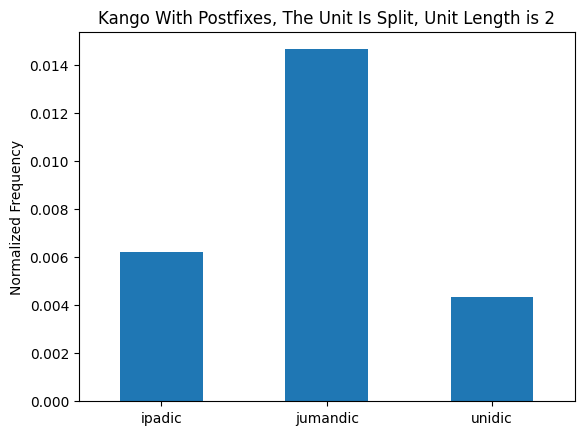

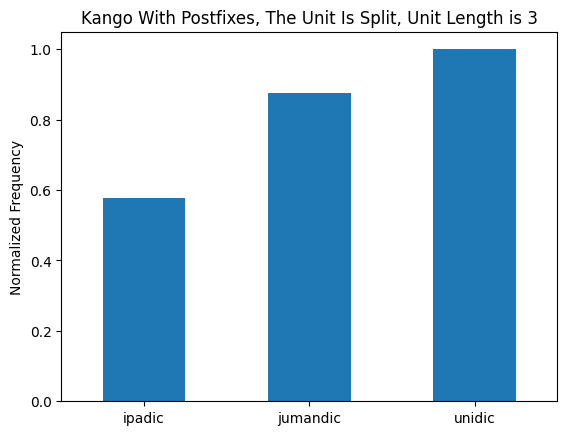

In [7]:
# покажем таблицу и график с краткой информацией по наличию сегментации по единицам-канго с постфиксами

show_summary_single_kind('kango_with_postfixes', 'the unit is split')

ipadic                              jumandic  \
                        frequencies     percentages           frequencies   
unexpected segmentation          NO YES          NO       YES          NO   
unit length                                                                 
2                             39762   0    1.000000  0.000000       39763   
3                             27973  48    0.998287  0.001713       26669   

                                                         unidic        \
                              percentages           frequencies         
unexpected segmentation   YES          NO       YES          NO   YES   
unit length                                                             
2                           0    1.000000  0.000000       39763     0   
3                        1354    0.951683  0.048317       26759  1264   

                                               
                        percentages            
unexpected segmentation          NO       YES  
unit length                                    
2                          1.000000  0.000000  
3                          0.954894  0.045106

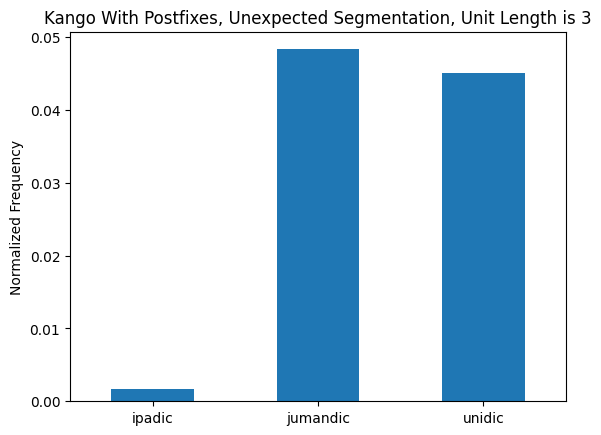

In [8]:
# покажем таблицу и график с краткой информацией по наличию неожиданной сегментации по единицам-канго с постфиксами

show_summary_single_kind('kango_with_postfixes', 'unexpected segmentation')

ipadic                               jumandic      \
                   frequencies      percentages           frequencies       
unexpected joining          NO  YES          NO       YES          NO YES   
unit length                                                                 
2                        39622  140    0.996479  0.003521       39676  87   
3                        27971   50    0.998216  0.001784       27970  53   

                                              unidic                            
                   percentages           frequencies     percentages            
unexpected joining          NO       YES          NO YES          NO       YES  
unit length                                                                     
2                     0.997812  0.002188       39671  92    0.997686  0.002314  
3                     0.998109  0.001891       27991  32    0.998858  0.001142

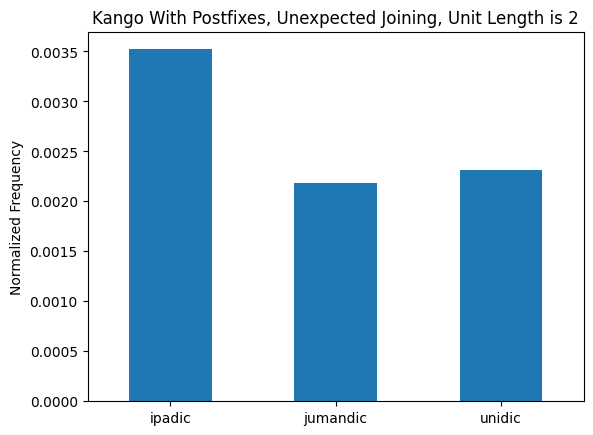

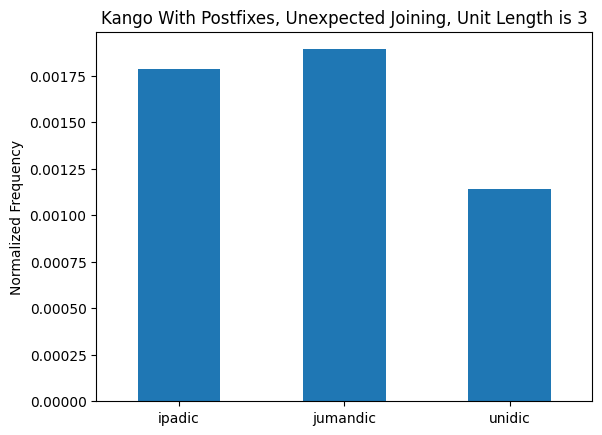

In [9]:
# покажем таблицу и график с краткой информацией по наличию неожиданного соединения с соседями по контексту 
# по единицам-канго с постфиксами

show_summary_single_kind('kango_with_postfixes', 'unexpected joining')

ipadic                                jumandic        \
                  frequencies       percentages           frequencies         
the unit is split          NO   YES          NO       YES          NO   YES   
unit length                                                                   
2                       23573   502    0.979148  0.020852       22609  1466   
3                        4613  5055    0.477141  0.522859        4602  5066   

                                             unidic                    \
                  percentages           frequencies       percentages   
the unit is split          NO       YES          NO   YES          NO   
unit length                                                             
2                    0.939107  0.060893       23972   103    0.995722   
3                    0.476003  0.523997         170  9498    0.017584   

                             
                             
the unit is split       YES  
unit length                  
2                  0.004278  
3                  0.982416

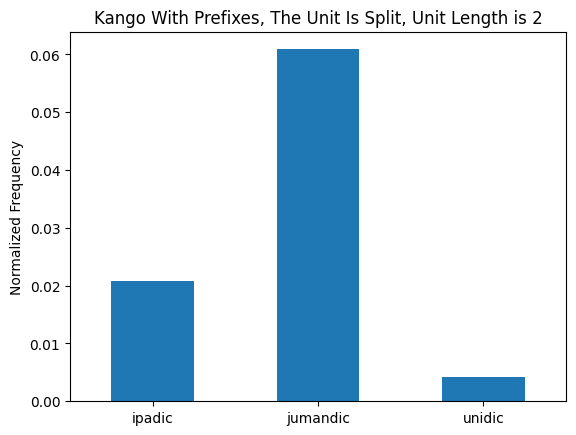

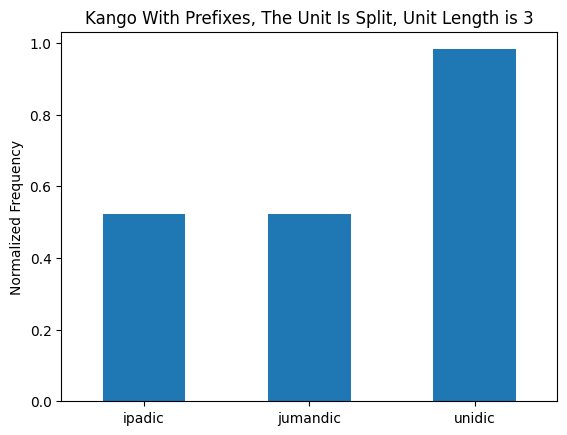

In [10]:
# покажем таблицу и график с краткой информацией по наличию сегментации по единицам-канго с префиксами

show_summary_single_kind('kango_with_prefixes', 'the unit is split')

ipadic                              jumandic      \
                        frequencies     percentages           frequencies       
unexpected segmentation          NO YES          NO       YES          NO YES   
unit length                                                                     
2                             24075   0    1.000000  0.000000       24075   0   
3                              9661   7    0.999276  0.000724        9666   2   

                                                   unidic                  \
                        percentages           frequencies     percentages   
unexpected segmentation          NO       YES          NO YES          NO   
unit length                                                                 
2                          1.000000  0.000000       24075   0    1.000000   
3                          0.999793  0.000207        9612  56    0.994208   

                                   
                                   
unexpected segmentation       YES  
unit length                        
2                        0.000000  
3                        0.005792

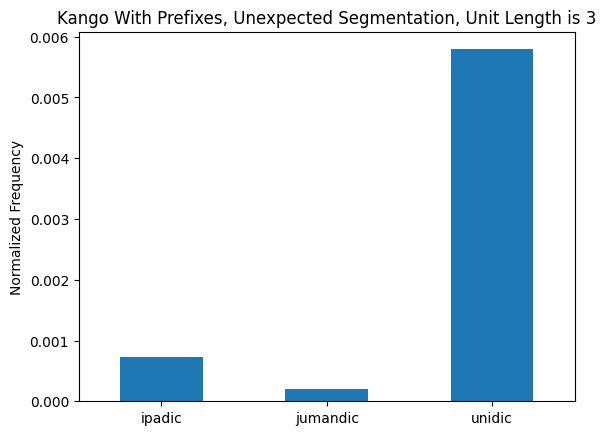

In [11]:
# покажем таблицу и график с краткой информацией по наличию неожиданной сегментации по единицам-канго с префиксами

show_summary_single_kind('kango_with_prefixes', 'unexpected segmentation')

ipadic                               jumandic        \
                   frequencies      percentages           frequencies         
unexpected joining          NO  YES          NO       YES          NO   YES   
unit length                                                                   
2                        23818  257    0.989325  0.010675       17297  6778   
3                         9665    3    0.999690  0.000310        6196  3472   

                                              unidic                            
                   percentages           frequencies     percentages            
unexpected joining          NO       YES          NO YES          NO       YES  
unit length                                                                     
2                     0.718463  0.281537       24041  34    0.998588  0.001412  
3                     0.640877  0.359123        9666   2    0.999793  0.000207

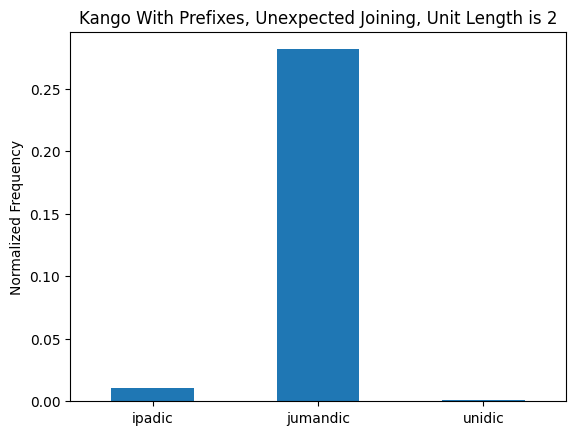

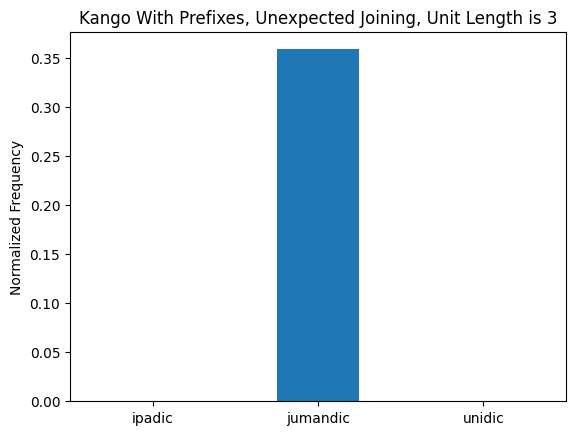

In [12]:
# покажем таблицу и график с краткой информацией по наличию неожиданной неожиданного соединения с соседями по контексту 
# по единицам-канго с постфиксами

show_summary_single_kind('kango_with_prefixes', 'unexpected joining')

ipadic                              jumandic      \
                  frequencies     percentages           frequencies       
the unit is split          NO YES          NO       YES          NO YES   
unit length                                                               
2                        4882   4    0.999181  0.000819        4877   9   
3                         205  32    0.864979  0.135021         204  33   

                                             unidic                             
                  percentages           frequencies      percentages            
the unit is split          NO       YES          NO  YES          NO       YES  
unit length                                                                     
2                    0.998158  0.001842        4867   19    0.996111  0.003889  
3                    0.860759  0.139241           0  237    0.000000  1.000000

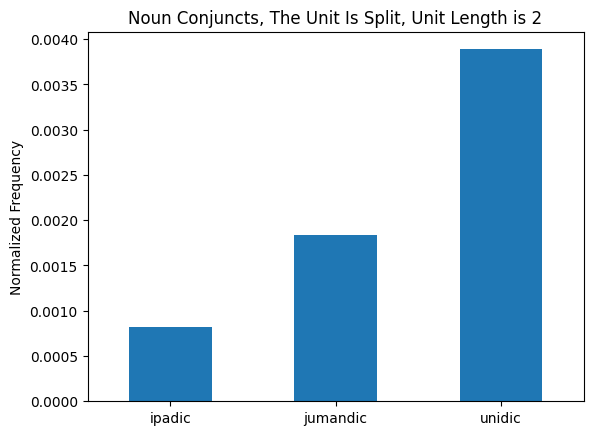

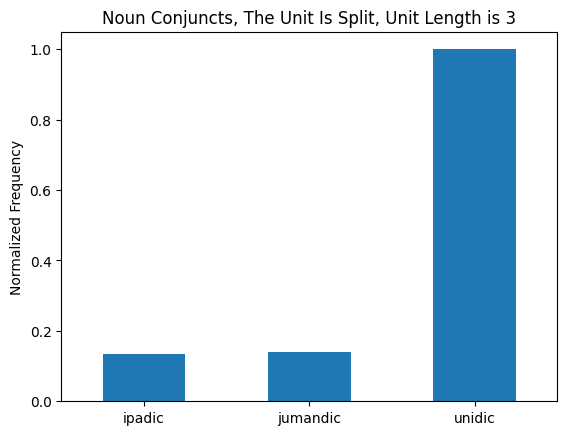

In [13]:
# покажем таблицу и график с краткой информацией по наличию сегментации по существительным с сочинительной связью между элементами

show_summary_single_kind('noun_conjuncts', 'the unit is split')

In [14]:
# покажем таблицу и график с краткой информацией по наличию неожиданной сегментации по единицам с сочинительной связью между элементами

show_summary_single_kind('noun_conjuncts', 'unexpected segmentation')

ipadic                jumandic              \
                        frequencies percentages frequencies percentages   
unexpected segmentation          NO          NO          NO          NO   
unit length                                                               
2                              4886         1.0        4886         1.0   
3                               237         1.0         237         1.0   

                             unidic              
                        frequencies percentages  
unexpected segmentation          NO          NO  
unit length                                      
2                              4886         1.0  
3                               237         1.0

ipadic                              jumandic        \
                   frequencies     percentages           frequencies         
unexpected joining          NO YES          NO       YES          NO   YES   
unit length                                                                  
2                         4796  90    0.981580  0.018420        3428  1458   
3                          232   5    0.978903  0.021097         233     4   

                                              unidic                   \
                   percentages           frequencies      percentages   
unexpected joining          NO       YES          NO  YES          NO   
unit length                                                             
2                     0.701596  0.298404        4777  109    0.977691   
3                     0.983122  0.016878         231    6    0.974684   

                              
                              
unexpected joining       YES  
unit length                   
2                   0.022309  
3                   0.025316

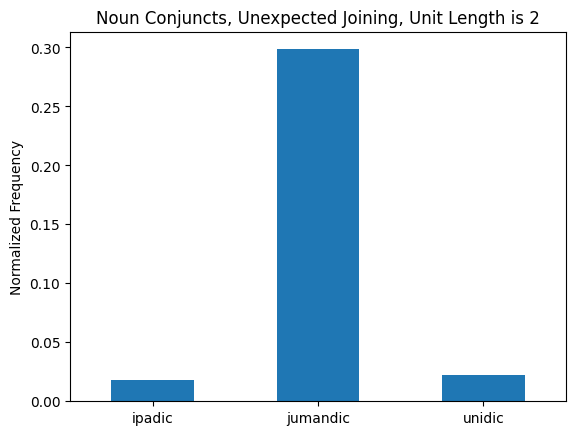

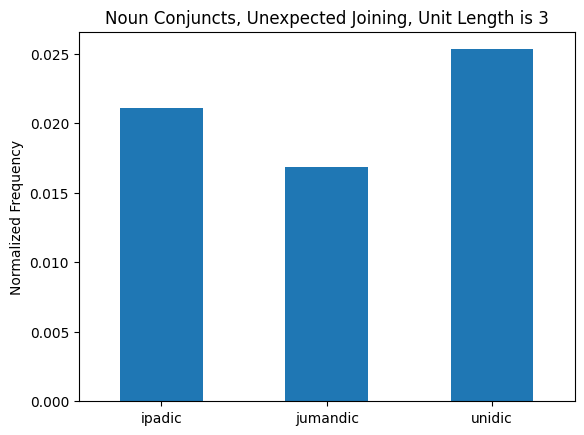

In [15]:
# покажем таблицу и график с краткой информацией по наличию неожиданной неожиданного соединения с соседями по контексту 
# по единицам с сочинительной связью между элементами

show_summary_single_kind('noun_conjuncts', 'unexpected joining')

ipadic                               jumandic       \
                    frequencies      percentages           frequencies        
the unit is split            NO  YES          NO       YES          NO  YES   
wago_nouns_longer          3355    7    0.997918  0.002082        2658  704   
wago_nouns_shorter         2789  226    0.925041  0.074959        2888  127   
wago_nouns_shortest        3268   94    0.972040  0.027960        3352   10   

                                               unidic                  \
                    percentages           frequencies     percentages   
the unit is split            NO       YES          NO YES          NO   
wago_nouns_longer      0.790601  0.209399        3358   4    0.998810   
wago_nouns_shorter     0.957877  0.042123        3006   9    0.997015   
wago_nouns_shortest    0.997026  0.002974        3274  88    0.973825   

                               
                               
the unit is split         YES  
wago_nouns_longer    0.001190  
wago_nouns_shorter   0.002985  
wago_nouns_shortest  0.026175

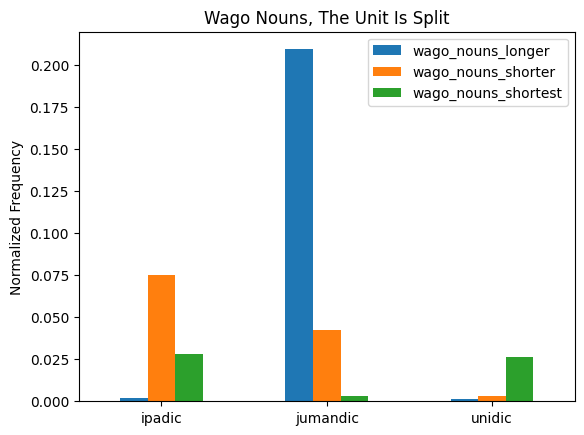

In [16]:
# покажем таблицу с краткой информацией по наличию сегментации по существительным-ваго 
# (у каждой единицы три варианта написания иероглифами)

kinds = ['wago_nouns_longer', 'wago_nouns_shorter', 'wago_nouns_shortest']
show_summary_multiple_kinds(kinds, 'the unit is split', 'wago nouns')

ipadic                                jumandic  \
                        frequencies       percentages           frequencies   
unexpected segmentation          NO   YES          NO       YES          NO   
wago_nouns_longer              3355   7.0    0.997918  0.002082        3350   
wago_nouns_shorter             2965  50.0    0.983416  0.016584        2932   
wago_nouns_shortest            3362   0.0    1.000000  0.000000        3362   

                                                         unidic       \
                              percentages           frequencies        
unexpected segmentation   YES          NO       YES          NO  YES   
wago_nouns_longer        12.0    0.996431  0.003569        3360  2.0   
wago_nouns_shorter       83.0    0.972471  0.027529        3011  4.0   
wago_nouns_shortest       0.0    1.000000  0.000000        3362  0.0   

                                               
                        percentages            
unexpected segmentation          NO       YES  
wago_nouns_longer          0.999405  0.000595  
wago_nouns_shorter         0.998673  0.001327  
wago_nouns_shortest        1.000000  0.000000

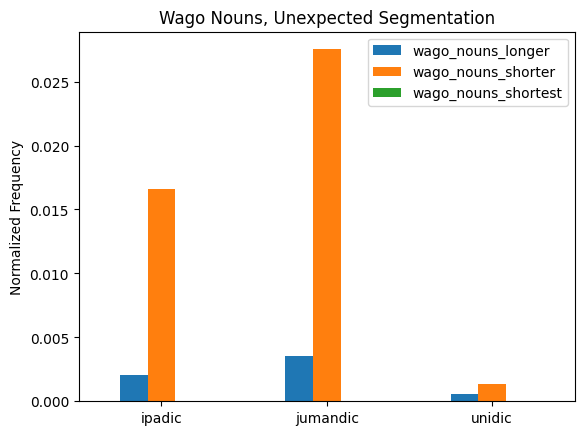

In [17]:
# покажем таблицу и график с краткой информацией по наличию неожиданной сегментации по существительным-ваго 
# (у каждой единицы три варианта написания иероглифами)

kinds = ['wago_nouns_longer', 'wago_nouns_shorter', 'wago_nouns_shortest']
show_summary_multiple_kinds(kinds, 'unexpected segmentation', 'wago nouns')

ipadic                              jumandic      \
                    frequencies     percentages           frequencies       
unexpected joining           NO YES          NO       YES          NO YES   
wago_nouns_longer          3351  11    0.996728  0.003272        3336  26   
wago_nouns_shorter         3001  14    0.995357  0.004643        2961  54   
wago_nouns_shortest        3285  77    0.977097  0.022903        3267  95   

                                               unidic                  \
                    percentages           frequencies     percentages   
unexpected joining           NO       YES          NO YES          NO   
wago_nouns_longer      0.992267  0.007733        3350  12    0.996431   
wago_nouns_shorter     0.982090  0.017910        3003  12    0.996020   
wago_nouns_shortest    0.971743  0.028257        3278  84    0.975015   

                               
                               
unexpected joining        YES  
wago_nouns_longer    0.003569  
wago_nouns_shorter   0.003980  
wago_nouns_shortest  0.024985

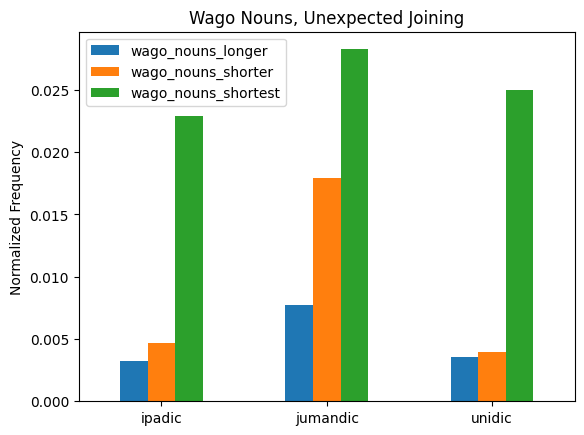

In [18]:
# покажем таблицу и график с краткой информацией по наличию неожиданной неожиданного соединения с соседями по контексту 
# по существительным-ваго (у каждой единицы три варианта написания иероглифами)

kinds = ['wago_nouns_longer', 'wago_nouns_shorter', 'wago_nouns_shortest']
show_summary_multiple_kinds(kinds, 'unexpected joining', 'wago nouns')

ipadic                                 jumandic  \
                   frequencies        percentages           frequencies   
the unit is split           NO    YES          NO       YES          NO   
wago_verbs_longer         3961   56.0    0.986059  0.013941        2340   
wago_verbs_shorter        3519  591.0    0.856204  0.143796        2962   

                                                      unidic          \
                           percentages           frequencies           
the unit is split      YES          NO       YES          NO     YES   
wago_verbs_longer   1677.0    0.582524  0.417476        4017     0.0   
wago_verbs_shorter  1148.0    0.720681  0.279319        2805  1305.0   

                                          
                   percentages            
the unit is split           NO       YES  
wago_verbs_longer     1.000000  0.000000  
wago_verbs_shorter    0.682482  0.317518

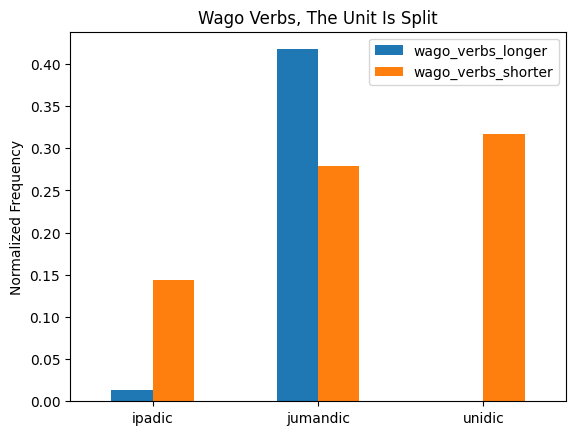

In [19]:
# покажем таблицу и график с краткой информацией по наличию сегментации по глаголам-ваго 
# (у каждой единицы два варианта написания иероглифами)

kinds = ['wago_verbs_longer', 'wago_verbs_shorter']
show_summary_multiple_kinds(kinds, 'the unit is split', 'wago verbs')

ipadic                                 jumandic  \
                        frequencies        percentages           frequencies   
unexpected segmentation          NO    YES          NO       YES          NO   
wago_verbs_longer              3963   54.0    0.986557  0.013443        4005   
wago_verbs_shorter             4006  104.0    0.974696  0.025304        3796   

                                                          unidic         \
                               percentages           frequencies          
unexpected segmentation    YES          NO       YES          NO    YES   
wago_verbs_longer         12.0    0.997013  0.002987        4017    0.0   
wago_verbs_shorter       314.0    0.923601  0.076399        3526  584.0   

                                               
                        percentages            
unexpected segmentation          NO       YES  
wago_verbs_longer          1.000000  0.000000  
wago_verbs_shorter         0.857908  0.142092

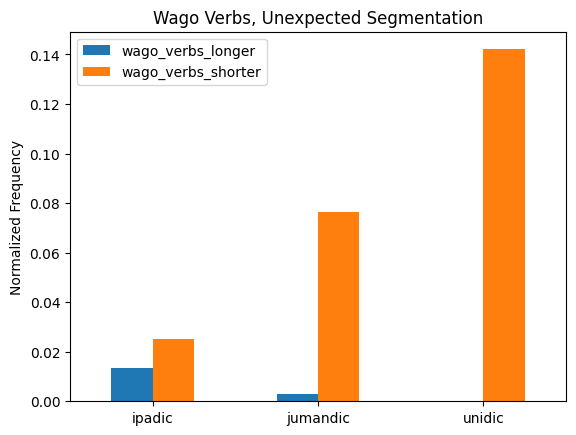

In [20]:
# покажем таблицу и график с краткой информацией по наличию неожиданной сегментации по глаголам-ваго 
# (у каждой единицы два варианта написания иероглифами)

kinds = ['wago_verbs_longer', 'wago_verbs_shorter']
show_summary_multiple_kinds(kinds, 'unexpected segmentation', 'wago verbs')

ipadic                              jumandic        \
                   frequencies     percentages           frequencies         
unexpected joining          NO YES          NO       YES          NO   YES   
wago_verbs_longer         4006  11    0.997262  0.002738        2205  1812   
wago_verbs_shorter        4093  17    0.995864  0.004136        2329  1781   

                                              unidic                            
                   percentages           frequencies     percentages            
unexpected joining          NO       YES          NO YES          NO       YES  
wago_verbs_longer     0.548917  0.451083        4009   8    0.998008  0.001992  
wago_verbs_shorter    0.566667  0.433333        4028  82    0.980049  0.019951

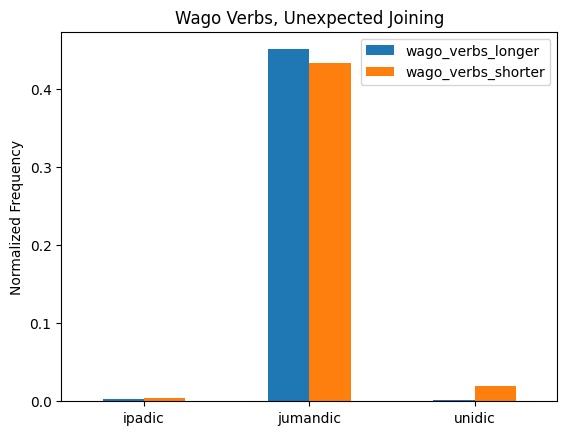

In [21]:
# покажем таблицу и график с краткой информацией по наличию неожиданной неожиданного соединения с соседями по контексту 
# по глаголам-ваго (у каждой единицы два варианта написания иероглифами)

kinds = ['wago_verbs_longer', 'wago_verbs_shorter']
show_summary_multiple_kinds(kinds, 'unexpected joining', 'wago verbs')